In [1]:
# in this notebook i want to try and load the ann-sur waveform into a pycbc
# time series so that it can be used in pycbc machinery

In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
import tensorflow as tf

In [4]:
from tensorflow_probability.python.math.interpolation import interp_regular_1d_grid
from tensorflow_probability.python.math import interpolation as tfp_interp

In [5]:
import os

In [6]:
import phenom

In [7]:
import lal

In [8]:
# from scrinet.sample.sample_helpers import predict_hackict_hack

In [9]:
from scrinet.interfaces import lalutils

In [10]:
from scrinet.workflow.pipe_utils import load_model

In [11]:
def setup_surrogate(user="sk"):
    if user == "sk":
#         rootdir = "/Users/spx8sk/work/data/scrinet/3D_NP"
        rootdir = "/Users/spx8sk/work/data/scrinet/ann-sur-final-model"
    elif user == "rg":
        rootdir = '/Users/Rhys/Documents/PhD/PE/NN_for_PE/3D_NP'
        
    amp_basis = os.path.join(rootdir, "amp_eim_basis.npy")
    amp_model_dir = os.path.join(rootdir, "results_4_320_relu_Adam")

    phase_basis = os.path.join(rootdir, "phase_eim_basis.npy")
    phase_model_dir = os.path.join(rootdir, "results_4_320_softplus_Adamax")

    amp_model, amp_basis = load_model(
        basis_file=amp_basis,
        nn_weights_file=os.path.join(amp_model_dir, "model.h5"),
        X_scalers_file=os.path.join(amp_model_dir, "X_scalers.npy"),
        Y_scalers_file=""
    )

    phase_model, phase_basis = load_model(
        basis_file=phase_basis,
        nn_weights_file=os.path.join(phase_model_dir, "model.h5"),
        X_scalers_file=os.path.join(phase_model_dir, "X_scalers.npy"),
        Y_scalers_file=os.path.join(phase_model_dir, "y_scalers.npy")
    )
    
    amp_basis = tf.convert_to_tensor(amp_basis, dtype = tf.float32)
    phase_basis = tf.convert_to_tensor(phase_basis, dtype = tf.float32)
    
    return amp_model, amp_basis, phase_model, phase_basis

In [12]:
# @tf.function(experimental_compile=True, autograph=True, experimental_relax_shapes=True)
def amp_predict_hack(model, _input):
    """
    Function to re-create model.predict(input) but allows the graph to be built correctly
    (see https://github.com/tensorflow/tensorflow/issues/33997)

    :param model: A trained scrinet Neural Network
    :param _input: The point at which you want to make a prediction
    :return:
    """
    x = _input
    x = x_scale_hack(model, x)
    pred = tf.convert_to_tensor(x)
    # the three should be an argument for ndim of problem
    pred = tf.reshape(pred, shape=(-1, 3))
    net_layers = model.model.layers
    output_shape = net_layers[-1].output_shape[-1]
    for layer in net_layers:
        pred = layer(pred)
    pred = tf.reshape(
        pred, shape=(-1, output_shape,))
    return pred


# @tf.function(experimental_compile=True, autograph=True, experimental_relax_shapes=True)
def phase_predict_hack(model, _input):
    """
    Function to re-create model.predict(input) but allows the graph to be built correctly
    (see https://github.com/tensorflow/tensorflow/issues/33997)

    :param model: A trained scrinet Neural Network
    :param _input: The point at which you want to make a prediction
    :return:
    """
    x = _input
    x = x_scale_hack(model, x)
    pred = tf.convert_to_tensor(x)
    # the three should be an argument for ndim of problem
    pred = tf.reshape(pred, shape=(-1, 3))
    net_layers = model.model.layers
    output_shape = net_layers[-1].output_shape[-1]
    for layer in net_layers:
        pred = layer(pred)
    pred = tf.reshape(
        pred, shape=(-1, output_shape,))
#     pred = y_inv_scale_hack(model, pred)
    pred = y_inv_minmax_scale_hack(model, pred)
    return pred


# @tf.function(experimental_compile=True, experimental_relax_shapes=True)
def x_scale_hack(model, _input):
    """
    Function to re-create sklearn standard scaler for the input (as a tensorflow function)

    :param model: A trained scrinet Neural Network
    :param _input: The point at which you want to scale
    :return:
    """
    x = _input
    means = tf.constant([model.X_scalers[i].mean_[0]
                         for i in range(x.shape[0])])
    stds = tf.constant([model.X_scalers[i].scale_[0]
                        for i in range(x.shape[0])])
    means = tf.cast(means, tf.float32)
    stds = tf.cast(stds, tf.float32)

    x_scaled = (tf.reshape(x, shape=(-1, x.shape[0],)) - means) / stds
    x_scaled = tf.cast(x_scaled, tf.float32)
    return x_scaled


# @tf.function(experimental_compile=True, experimental_relax_shapes=True)
def get_model_y_std_scalers(model, _input):
    """
    Re-casts the sklearn output std scalers for each output basis

    :param model: A trained scrinet Neural Network
    :param _input: The point at which you want to scale
    :return:
    """
    std = [model.Y_scalers[i].scale_[0] for i in range(_input.shape[1])]
    std = tf.stack(std, axis=0)
    std = tf.cast(std, tf.float32)
    return std


# @tf.function(experimental_compile=True, experimental_relax_shapes=True)
def get_model_y_mean_scalers(model, _input):
    """
    Re-casts the sklearn output mean scalers for each output basis

    :param model: A trained scrinet Neural Network
    :param _input: The point at which you want to scale
    :return:
    """
    mean = [model.Y_scalers[i].mean_[0] for i in range(_input.shape[1])]
    mean = tf.stack(mean, axis=0)
    mean = tf.cast(mean, tf.float32)
    return mean


# @tf.function(experimental_compile=True, experimental_relax_shapes=True)
def y_inv_scale_hack(model, _input):
    """
    Re-creates the sklearn inverse standard scaler as a tensorflow function,

    :param model: A trained scrinet Neural Network
    :param _input: The point at which you want to scale
    :return:
    """
    y_scaled = _input
    y_scaled = tf.reshape(y_scaled, shape=(-1, y_scaled.shape[1]))

    mean = get_model_y_mean_scalers(model, _input)

    std = get_model_y_std_scalers(model, _input)
    y = y_scaled * std + mean
    return y

# @tf.function(experimental_compile=True, experimental_relax_shapes=True)
def get_model_y_minmax_scale_scalers(model, _input):
    """
    Re-casts the sklearn output scale scalers for each output basis

    :param model: A trained scrinet Neural Network
    :param _input: The point at which you want to scale
    :return:
    """
    scale = [model.Y_scalers[i].scale_[0] for i in range(_input.shape[1])]
    scale = tf.stack(scale, axis=0)
    scale = tf.cast(scale, tf.float32)
    return scale


# @tf.function(experimental_compile=True, experimental_relax_shapes=True)
def get_model_y_minmax_min_scalers(model, _input):
    """
    Re-casts the sklearn output min scalers for each output basis

    :param model: A trained scrinet Neural Network
    :param _input: The point at which you want to scale
    :return:
    """
    mins = [model.Y_scalers[i].min_[0] for i in range(_input.shape[1])]
    mins = tf.stack(mins, axis=0)
    mins = tf.cast(mins, tf.float32)
    return mins


# @tf.function(experimental_compile=True, experimental_relax_shapes=True)
def y_inv_minmax_scale_hack(model, _input):
    """
    Re-creates the sklearn inverse standard scaler as a tensorflow function,

    :param model: A trained scrinet Neural Network
    :param _input: The point at which you want to scale
    :return:
    """
    y_scaled = _input
    y_scaled = tf.reshape(y_scaled, shape=(-1, y_scaled.shape[1]))

    mins = get_model_y_minmax_min_scalers(model, _input)

    scale = get_model_y_minmax_scale_scalers(model, _input)
    y = (y_scaled - mins) / scale
    return y


In [13]:
amp_model, amp_basis, phase_model, phase_basis = setup_surrogate(user="sk")

In [14]:
amp_basis.shape

TensorShape([19, 40000])

In [15]:
phase_basis.shape

TensorShape([8, 40000])

In [16]:
# based on generate_surrogate in sample_helpers.py
def generate_surrogate_amp_phase(
    x, amp_model, amp_basis, phase_model, phase_basis, phase_shift=0.0
):
    """
    generate hplus and hcross

    :param times: time axis shape = (1, len(surrogte basis))
    :param mtotal: total mass

    :param x: The location in parameter space - currently (q, chi1, chi2)
    :param amp_model: The pre-loaded amplitude nn generator
    :param amp_basis: The pre-loaded amplitude basis
    :param phase_model: The pre-loaded phase nn generator
    :param phase_basis: The pre-loaded phase basis
    :param phase_shift: phase shift (default: 0.)
    :return:
    """

    x = tf.transpose(tf.stack([tf.math.log(x[:, 0]), x[:, 1], x[:, 2]], axis=0))
    x = tf.cast(x, tf.float32)
    x = tf.reshape(x, shape=(-1, x.shape[0]))
    x = tf.convert_to_tensor(x, dtype=tf.float32)

    amp_alpha = amp_predict_hack(amp_model, x)

    amp = tf.tensordot(amp_alpha, amp_basis, axes=1)

    phase_alpha = phase_predict_hack(phase_model, x)

    phase = tf.tensordot(phase_alpha, phase_basis, axes=1)

    phase_shift = tf.cast(phase_shift, dtype=phase.dtype)

    phase = phase + phase_shift

    return amp, phase

In [17]:
val_wf_data = np.load("/Users/spx8sk/work/data/scrinet/ann-sur-final-model/wfval-t-amp-phi.npy")
val_wf_params = np.load("/Users/spx8sk/work/data/scrinet/ann-sur-final-model/wfval-params.npy")

In [18]:
val_wf_params

array([[ 4.51022128, -0.59416007,  0.65381006]])

In [19]:
amp, phase = generate_surrogate_amp_phase(val_wf_params, amp_model, amp_basis, phase_model, phase_basis)

In [20]:
times_M = tf.linspace(-20000., 100., 40000)

In [21]:
amp.shape

TensorShape([1, 40000])

In [22]:
phase.shape

TensorShape([1, 40000])

(-100, 100)

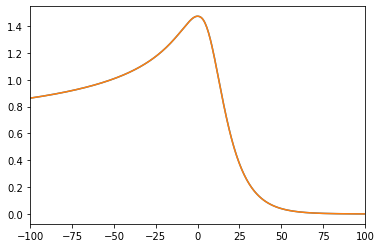

In [23]:
plt.figure()
plt.plot(times_M, amp[0])
plt.plot(val_wf_data[:,0], val_wf_data[:,1])
plt.xlim(-100, 100)

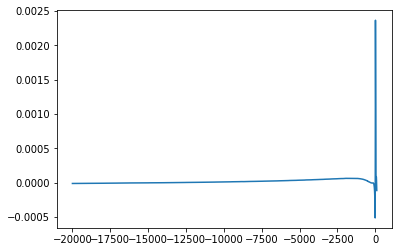

In [24]:
plt.figure()
plt.plot(times_M, amp[0]-val_wf_data[:,1])
# plt.xlim(-100, 100)

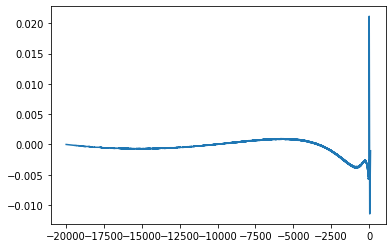

In [25]:
plt.figure()
plt.plot(times_M, phase[0]-val_wf_data[:,2])

In [26]:
params = tf.constant([[1., 0, 0,]], tf.float32)

In [27]:
amp, phase = generate_surrogate_amp_phase(params, amp_model, amp_basis, phase_model, phase_basis)

In [28]:
times_M = tf.linspace(-20000., 100., 40000)

In [29]:
amp.shape

TensorShape([1, 40000])

In [30]:
phase.shape

TensorShape([1, 40000])

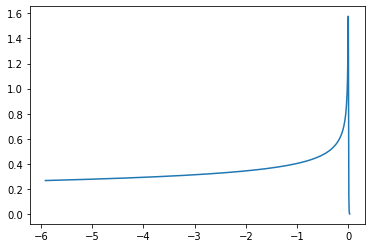

In [31]:
plt.figure()
plt.plot(phenom.MtoS(60, times_M), amp[0])
# plt.xlim(-100, 100)

In [32]:
# we need a function to tell us the time before merger for a particular frequency
# we can estimate this using PN
# from https://github.com/gwastro/pycbc/blob/master/pycbc/waveform/spa_tmplt.py
# non-spinning only
# removed the 'porder' and hardcoding max-order
# @tf.function(experimental_relax_shapes=True)
# @tf.function()
def tf_findchirp_chirptime(m1, m2, fLower):
    # variables used to compute chirp time
    m = m1 + m2
    eta = m1 * m2 / m / m
    c0T = c2T = c3T = c4T = c5T = c6T = c6LogT = c7T = 0.

    c7T = lal.PI * (14809.0 * eta * eta / 378.0 - 75703.0 * eta / 756.0 - 15419335.0 / 127008.0)

    c6T = lal.GAMMA * 6848.0 / 105.0 - 10052469856691.0 / 23471078400.0 +\
        lal.PI * lal.PI * 128.0 / 3.0 + \
        eta * (3147553127.0 / 3048192.0 - lal.PI * lal.PI * 451.0 / 12.0) -\
        eta * eta * 15211.0 / 1728.0 + eta * eta * eta * 25565.0 / 1296.0 +\
        eta * eta * eta * 25565.0 / 1296.0 + tf.math.log(4.0) * 6848.0 / 105.0
    c6LogT = 6848.0 / 105.0

    c5T = 13.0 * lal.PI * eta / 3.0 - 7729.0 * lal.PI / 252.0

    c4T = 3058673.0 / 508032.0 + eta * (5429.0 / 504.0 + eta * 617.0 / 72.0)
    c3T = -32.0 * lal.PI / 5.0
    c2T = 743.0 / 252.0 + eta * 11.0 / 3.0
    c0T = 5.0 * m * lal.MTSUN_SI / (256.0 * eta)

    # This is the PN parameter v evaluated at the lower freq. cutoff
    xT = tf.pow (lal.PI * m * lal.MTSUN_SI * fLower, 1.0 / 3.0)
    x2T = xT * xT
    x3T = xT * x2T
    x4T = x2T * x2T
    x5T = x2T * x3T
    x6T = x3T * x3T
    x7T = x3T * x4T
    x8T = x4T * x4T

    # Computes the chirp time as tC = t(v_low)
    # tC = t(v_low) - t(v_upper) would be more
    # correct, but the difference is negligble.

    # This formula works for any PN order, because
    # higher order coeffs will be set to zero.
    return c0T * (1 + c2T * x2T + c3T * x3T + c4T * x4T + c5T * x5T + (c6T + c6LogT * tf.math.log(xT)) * x6T + c7T * x7T) / x8T

In [33]:
# not sure how good this estimate is
tf_findchirp_chirptime(30., 30., 8)

<tf.Tensor: shape=(), dtype=float32, numpy=10.883546>

In [34]:
# not sure how good this estimate is
tf_findchirp_chirptime(30., 30., 10)

<tf.Tensor: shape=(), dtype=float32, numpy=5.8919473>

In [35]:
# vectorising tf_findchirp_chirptime
expected_result_chirptime = tf.convert_to_tensor([tf_findchirp_chirptime(30., 30., 24.), tf_findchirp_chirptime(29., 22., 12.)])
print(expected_result_chirptime)

tf.Tensor([0.46389768 4.8259873 ], shape=(2,), dtype=float32)


In [36]:
x1 = tf.convert_to_tensor([30., 29.])
x2 = tf.convert_to_tensor([30., 22.])
x3 = tf.convert_to_tensor([24., 12.])

In [37]:
tf_findchirp_chirptime(x1,x2,x3)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.46389815, 4.8259873 ], dtype=float32)>

In [38]:
??phenom.StoM

Signature: phenom.StoM(S, Mtot)
Source:   
def StoM(S, Mtot):
    """StoM(S, Mtot)
    """
    return S / (Constants.MTSUN_SI*Mtot)
File:      ~/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/phenom/utils/utils.py
Type:      function


In [39]:
# tf.debugging.assert_greater_equal([1,2], [3,4])

In [616]:
# @tf.function(experimental_compile=True)
# @tf.function()
def tf_get_surrogate_index_and_value_at_f_lower(m1,m2,flower):
    """
    returns the first index above the input flower
    and the value at that index
    """
    time_at_flower_sec = -tf_findchirp_chirptime(m1,m2,flower)
    time_at_flower_M = tf.cast(phenom.StoM(time_at_flower_sec, m1+m2), tf.float64)
    
    # hardcoded to the final ann-sur model
    tstart_M = tf.cast(-20000., tf.float64)
    tend_M = 100.
    tnum = 40000
    
    # comment this out to support XLA compilation
#     tf.debugging.assert_greater_equal(
#         time_at_flower_M,
#         tstart_M,
#         message=f"error: flower too low. flower = {flower}. time_at_flower_M = {time_at_flower_M}"
#     )
    
    surrogate_times = tf.linspace(tstart_M, tend_M, tnum)
    dt_M = surrogate_times[1] - surrogate_times[0]
    
    target_indexs = tf.cast(tf.floor((20000. + time_at_flower_M) / dt_M), tf.int32)
    
    vals = tf.gather(surrogate_times, target_indexs)
    
    return target_indexs, vals

In [41]:
tf_get_surrogate_index_and_value_at_f_lower(30., 30., 10)

(<tf.Tensor: shape=(), dtype=int32, numpy=125>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-19937.18592964824>)

In [42]:
tf_get_surrogate_index_and_value_at_f_lower(30., 30., 10)

(<tf.Tensor: shape=(), dtype=int32, numpy=125>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-19937.18592964824>)

In [43]:
# tf_get_surrogate_index_and_value_at_f_lower(tf.constant([30., 20.]), tf.constant([30., 20.]), 30)

In [44]:
tf_get_surrogate_index_and_value_at_f_lower(30., 30., 24.)

(<tf.Tensor: shape=(), dtype=int32, numpy=36676>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-1569.8492462311588>)

In [45]:
tf_get_surrogate_index_and_value_at_f_lower(30., 30., 24.)

(<tf.Tensor: shape=(), dtype=int32, numpy=36676>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-1569.8492462311588>)

In [46]:
tf_get_surrogate_index_and_value_at_f_lower(29., 22., 12.)

(<tf.Tensor: shape=(), dtype=int32, numpy=1568>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-19212.06030150754>)

In [47]:
tf_get_surrogate_index_and_value_at_f_lower(29., 22., 11.828)

(<tf.Tensor: shape=(), dtype=int32, numpy=8>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-19995.979899497488>)

In [48]:
# vectorising tf_get_surrogate_index_and_value_at_f_lower
expected_result_idx = ([tf_get_surrogate_index_and_value_at_f_lower(30., 30., 24.),
                        tf_get_surrogate_index_and_value_at_f_lower(29., 22., 12.),
                        tf_get_surrogate_index_and_value_at_f_lower(60., 90., 31.1231)])

In [49]:
expected_result_idx

[(<tf.Tensor: shape=(), dtype=int32, numpy=36676>,
  <tf.Tensor: shape=(), dtype=float64, numpy=-1569.8492462311588>),
 (<tf.Tensor: shape=(), dtype=int32, numpy=1568>,
  <tf.Tensor: shape=(), dtype=float64, numpy=-19212.06030150754>),
 (<tf.Tensor: shape=(), dtype=int32, numpy=39888>,
  <tf.Tensor: shape=(), dtype=float64, numpy=44.22110552763479>)]

In [50]:
x1 = tf.convert_to_tensor([30., 29., 60.])
x2 = tf.convert_to_tensor([30., 22., 90.])
x3 = tf.convert_to_tensor([24., 12., 31.1231])

In [51]:
tf_get_surrogate_index_and_value_at_f_lower(x1, x2, x3)

(<tf.Tensor: shape=(3,), dtype=int32, numpy=array([36676,  1568, 39888], dtype=int32)>,
 <tf.Tensor: shape=(3,), dtype=float64, numpy=array([ -1569.84924623, -19212.06030151,     44.22110553])>)

In [52]:
# pycbc interface
# get_td_waveform(m1, m2, s1, s2, f_lower, delta_t)

In [53]:
tf.math.sqrt(2.)

<tf.Tensor: shape=(), dtype=float32, numpy=1.4142135>

In [54]:
# @tf.function
def y22_func(theta, phi):
    """
    https://lscsoft.docs.ligo.org/lalsuite/lal/_spherical_harmonics_8c_source.html#l00042
    """
    fac = tf.math.sqrt( 5.0 / ( 64.0 * lal.PI ) ) * ( 1.0 + tf.math.cos( theta ))*( 1.0 + tf.math.cos( theta ))
    
    m = tf.cast(2., tf.complex64)
    return tf.math.exp(1.j * m * tf.cast(phi, tf.complex64)) * tf.cast(fac, tf.complex64)

# @tf.function
def y2m2_func(theta, phi):
    """
    https://lscsoft.docs.ligo.org/lalsuite/lal/_spherical_harmonics_8c_source.html#l00042
    """
    fac = tf.math.sqrt( 5.0 / ( 64.0 * lal.PI ) ) * ( 1.0 - tf.math.cos( theta ))*( 1.0 - tf.math.cos( theta ))
    
    m = tf.cast(-2., tf.complex64)
    return tf.math.exp(1.j * m * tf.cast(phi, tf.complex64)) * tf.cast(fac, tf.complex64)

In [55]:
y22_func(1.234,5.3134)

<tf.Tensor: shape=(), dtype=complex64, numpy=(-0.100623526-0.2603763j)>

In [56]:
y2m2_func(1.234,5.3134)

<tf.Tensor: shape=(), dtype=complex64, numpy=(-0.025482321+0.065938786j)>

In [57]:
lal.SpinWeightedSphericalHarmonic(1.234,5.3134,-2,2,2)

(-0.10062341913130443-0.26037637266407176j)

In [58]:
lal.SpinWeightedSphericalHarmonic(1.234,5.3134,-2,2,-2)

(-0.02548229391366076+0.06593879748551067j)

In [59]:
y22_func(0.,0.)

<tf.Tensor: shape=(), dtype=complex64, numpy=(0.63078314+0j)>

In [60]:
y2m2_func(0.,0.)

<tf.Tensor: shape=(), dtype=complex64, numpy=0j>

In [61]:
t1 = tf.constant([1.234, 0.])
p1 = tf.constant([5.3134, 0.])

In [62]:
y22_func(t1, p1)

<tf.Tensor: shape=(2,), dtype=complex64, numpy=array([-0.10062353-0.2603763j,  0.63078314+0.j       ], dtype=complex64)>

In [63]:
y2m2_func(t1, p1)

<tf.Tensor: shape=(2,), dtype=complex64, numpy=array([-0.02548232+0.06593879j,  0.        +0.j        ], dtype=complex64)>

In [64]:
phenom.m1_m2_M_q(
    tf.constant([100., 50.], dtype=tf.float64),
    tf.constant([1., 2.], dtype=tf.float64)
)

(<tf.Tensor: shape=(2,), dtype=float64, numpy=array([50.        , 33.33333333])>,
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([50.        , 16.66666667])>)

In [65]:
??phenom.m1_m2_M_q

Signature: phenom.m1_m2_M_q(M, q)
Source:   
def m1_m2_M_q(M, q):
    """
    Assumes m1 >= m2
    Computes the component masses m1 and m2
    from the total mass and mass-ratio.
    input: M, q
    output: m1, m2
    """
    m1 = M*q/(1.+q)
    m2 = M/(1.+q)
    return m1, m2
File:      ~/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/phenom/utils/utils.py
Type:      function


In [66]:
tf.argmin(tf.constant([3., 5., 2., 1., 9.]))

<tf.Tensor: shape=(), dtype=int64, numpy=3>

In [188]:
# N = 2
# M = 10

# start_end = [[2, 8], [4, 6]]

# @tf.function(experimental_compile=True)
# @tf.function()
def make_rect_window_tensor(M, start_end):
    B = []
    for se in start_end:
#         print(se)
#         print(se[0])
#         print(se[1])
#         print("sss", se[1]-se[0])
#         B.append([1]*(se[1]-se[0]))
        B.append( tf.ones(se[1]-se[0]) )
#         print(B)
    C = [tf.pad(B[i], [[start_end[i][0], M-start_end[i][1]]]) for i in range(len(start_end))]
    return tf.convert_to_tensor(C)

In [189]:
make_rect_window_tensor(10, [[0,10], [0, 10]])

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)>

In [190]:
num_T_i32 = tf.constant(10, tf.int32)
window = make_rect_window_tensor(num_T_i32, [ [0,num_T_i32], [0,num_T_i32] ])

In [191]:
window

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)>

In [370]:
def apply_roll(tensor_in, shifts):
    return tf.convert_to_tensor([tf.roll(tensor_in[i], shifts[i], axis=0) for i in range(tensor_in.shape[0])])

In [617]:
# based on generate_surrogate in sample_helpers.py
@tf.function(experimental_compile=True)
# @tf.function()
def generate_surrogate_hp_hc(
    x,
    f_lower,
    seglen,
    sample_rate,
    theta,
    phi,
    mtot, 
    dist,
    phase_shift,
    amp_model,
    amp_basis,
    phase_model,
    phase_basis
):
    """
    generate hplus and hcross

    f_lower, : shape = scalar
    seglen, : shape = scalar in seconds - duration of output times
    sample_rate, : shape = scalar in seconds

    :param theta: sphharm polar : shape = N,1
    :param phi: sphharm azimuth : shape = N,1
    :param mtot: total mass in Msun : shape = N,1
    :param dist: distance in metre : shape = N,1

    :param x: The location in parameter space - currently (q, chi1, chi2) : shape = N,3
    :param amp_model: The pre-loaded amplitude nn generator
    :param amp_basis: The pre-loaded amplitude basis
    :param phase_model: The pre-loaded phase nn generator
    :param phase_basis: The pre-loaded phase basis
    :param phase_shift: phase shift (default: 0.) : shape = N,1
    :return:
    
    
        the returned data have the sample sample-rate and duration.
        they have different start frequencies.
        They have the start frequency of the lowest in the batch.
        This should be fine for likelihood as we will choose a [kmin,kmax] pair that
        will encompass this.
        If you want the actual length of the waveform from that desired frequency though you should
        just use this function with a batch size of 1.
    
    """
    N = x.shape[0]
    sample_rate_M = phenom.StoM(sample_rate, mtot)
    
    q = tf.transpose(tf.expand_dims(x[:, 0], 0))
#     print(q)
    m1, m2 = phenom.m1_m2_M_q(mtot, q)

    x = tf.transpose(tf.stack([tf.math.log(x[:, 0]), x[:, 1], x[:, 2]], axis=0))
    x = tf.cast(x, tf.float32)
    x = tf.reshape(x, shape=(-1, x.shape[0]))
    x = tf.convert_to_tensor(x, dtype=tf.float32)

    amp_alpha = amp_predict_hack(amp_model, x)
    amp = tf.tensordot(amp_alpha, amp_basis, axes=1)
    phase_alpha = phase_predict_hack(phase_model, x)
    phase = tf.tensordot(phase_alpha, phase_basis, axes=1)
    phase_shift = tf.cast(phase_shift, dtype=phase.dtype)
    phase = phase + phase_shift
    
#     amp_pre_fac = tf.expand_dims(lalutils.td_amp_scale(mtot, dist) * phenom.eta_from_q(q), 1)

#     print("1")
#     print(lalutils.td_amp_scale(mtot, dist))
#     print("2")
#     print(phenom.eta_from_q(q))
    amp_pre_fac = lalutils.td_amp_scale(mtot, dist) * phenom.eta_from_q(q)
    
#     print(amp.shape)
#     print(amp_pre_fac)
    
    amp = amp * amp_pre_fac
    
    idx, val = tf_get_surrogate_index_and_value_at_f_lower(m1, m2, f_lower)
    
#     print(f"idx = {idx}")
#     print(f"val = {val}")
    
    original_idx = idx
    original_val = val # i think this can be use to estimate the epoch
    
#     print(val)
#     print(idx, val)
#     print(f"argmin: {tf.argmin(idx)}")
    val_idx = tf.argmin(idx)[0]
    idx = idx[tf.argmin(idx)[0],0]
#     print(f"idx: {idx}")
#     print(f"val: {val}")
#     print(f"val_idx: {val_idx}")
    val = tf.cast(val[val_idx, 0], dtype=tf.float32)
    
#     print(idx)
#     print(val)
    
    # we can't interpolate onto different length grids
    # because tensorflow tensors needs to have constant length rows.
    # or can use ragged tensors?
    #
    # so lets just take the longests waveform, lowests 'val'
    
    # these numbers are specific to the time axis of the surrogate
    x_ref_min = -20000.
# #     x_ref_min = val
    x_ref_max = 100.
#     times_M = tf.range(val, x_ref_max, sample_rate)
    
#     iy = interp_regular_1d_grid(
#         x=times_M, x_ref_min=x_ref_min, x_ref_max=x_ref_max, y_ref=tf.stack((amp[:,idx:], phase[:,idx:]))
#     )

#     print(tf.cast(amp[:,idx:].shape[1], tf.float64))
#     5664

    tfdt = tf.cast(sample_rate_M, tf.float64)
    
        
#     times_M = (tf.range(tf.cast(5664, tf.float64))) * tfdt - tf.abs(tf.cast(val, tf.float64))
    # to support XLA compilation need to get 'amp[:,idx:].shape[1]' from somewhere else?
    # i suppose the times could be an input to this function? 
    # the same goes for the tf_get_surrogate_index_and_value_at_f_lower function.
    # to get XLA to work with this function these need to be computed before hand.
#     times_M = (tf.range(tf.cast(amp[:,idx:].shape[1], tf.float64))) * tfdt - tf.abs(tf.cast(val, tf.float64))

    num_T = tf.cast(tf.cast(seglen / sample_rate, tf.int32), tf.float64)
#     print(num_T)
    times_M = tf.range(num_T) * tfdt - tf.abs(tf.cast(val, tf.float64))
    times_M_f32 = tf.cast(times_M, tf.float32)
#     print(f"val = {val}")
#     print(times_M)

    x_ref_min = val * tf.ones(N)
    x_ref_max = x_ref_max * tf.ones(N)

    iy = tfp_interp.batch_interp_regular_1d_grid(
        x=times_M_f32,
        x_ref_min=x_ref_min,
        x_ref_max=x_ref_max,
        y_ref=tf.stack((amp[:,idx:], phase[:,idx:])),
#         fill_value=0 # comment this line out to work with tf.function.... not sure why....
    )

#     x_ref_min = -20000
#     x_ref_max = 100
#     times_M = tf.range(val, x_ref_max, sample_rate)
#     iy = interp_regular_1d_grid(
#         x=times_M, x_ref_min=x_ref_min, x_ref_max=x_ref_max, y_ref=tf.stack((amp, phase)))


    new_amp = iy[0]
    new_phase = iy[1]

    phase = tf.cast(new_phase, tf.complex64)
    amp = tf.cast(new_amp, tf.complex64)
    
    theta = tf.cast(theta, tf.float32)
    phi = tf.cast(phi, tf.float32)
    
    h22 = amp * tf.math.exp(-1.j * phase)
    
#     hplus = np.real(0.5 * (h22 + tf.math.conj(h22)))
#     hcross = np.real(1.j * 0.5 * (h22 - tf.math.conj(h22)))

    y22 = y22_func(theta, phi)
    y2m2 = y2m2_func(theta, phi)

    h = h22*y22 + tf.math.conj(h22)*y2m2
    
    hplus = tf.math.real(h)
    hcross = tf.math.imag(h)
    
#     return tf.math.real(hplus), tf.math.real(hcross)

    surr_times_sec = phenom.MtoS(
        times_M,
        tf.cast(mtot, tf.float64)
    )
    
    
    
    # negative becuase these times start at negative values
    epochs = -surr_times_sec[:,0][:,tf.newaxis]

    surr_times_sec = surr_times_sec + epochs

    
    # finally here lets pad to the desired seglen
    # right now all waveforms have the same shape and sample-rate
    # so padding to desired seglen should be easy
    # tf.pad?
    
    start_times = phenom.MtoS(original_val, tf.cast(mtot, tf.float64))
    
    index_start_freq = tf.cast((epochs+start_times) / sample_rate, tf.int32)

    extra_time = phenom.MtoS(150, tf.cast(mtot, tf.float64))
    
    index_peak_amp = tf.cast((epochs+extra_time)/sample_rate, tf.int32)

    num_T_i32 = tf.cast(num_T, tf.int32)
    ab = tf.transpose((index_start_freq, index_peak_amp))
    
    window = make_rect_window_tensor(num_T_i32, [ ab[0,i] for i in range(N)])
    
#     return surr_times_sec, hplus*window, hcross*window, epochs, start_times
    return surr_times_sec, apply_roll(hplus*window, -tf.reshape(index_start_freq, (N,))), apply_roll(hcross*window, -tf.reshape(index_start_freq, (N,))), epochs, start_times
#     return surr_times_sec, tf.roll(hplus*window, -index_start_freq, axis=0), hcross*window, epochs, start_times

    


#     return surr_times_sec, hplus*window, hcross, new_epochs
#     return times_M, hplus, hcross

In [618]:
# x = tf.constant([
#     [1,0,0],
#     [2,0,0]
# ], dtype=np.float32)
# theta = tf.constant([[np.pi/3], [np.pi/2]])
# phi = tf.constant([[0.], [np.pi/2]])
# mtot = tf.constant([[60.], [80.]])
# dist = tf.constant([[1.],[2.]])
# phase_shift = tf.constant([[1.],[2.]])


x = tf.constant([
    [1,0,0],
    [2,0,0],
    [8,0,0]
], dtype=np.float32)
theta = tf.constant([[np.pi/3], [np.pi/2], [np.pi/4]])
phi = tf.constant([[0.], [np.pi/2], [np.pi/8]])
mtot = tf.constant([[60.], [60.], [60.]])
dist = tf.constant([[1.],[2.],[2.3]])
phase_shift = tf.constant([[1.],[2.],[-1.23]])


f_lower = 20


seglen = 4.

# only works upto samples rates of about this
sample_rate = 1/2048./2
# sample_rate_M = phenom.StoM(1/2048./2, mtot)

# sample_rate_M = phenom.StoM(1/2048./2/2, 60)


In [619]:
# # f_lower and sample-rate should always be constant and so can just be scalars (0-D Tensor)
surr_times_sec, hplus, hcross, epochs, start_times = generate_surrogate_hp_hc(
    x=x,
    f_lower=f_lower,
    seglen=seglen,
    sample_rate=sample_rate,
    theta=theta,
    phi=phi,
    mtot=mtot,
    dist=dist,
    phase_shift=phase_shift,
    amp_model=amp_model,
    amp_basis=amp_basis,
    phase_model=phase_model,
    phase_basis=phase_basis
)

In [620]:
# tf.reshape(epochs, (3,))

In [621]:
epochs * sample_rate

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[0.0004527],
       [0.0004527],
       [0.0004527]])>

In [622]:
epochs

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[1.8542618],
       [1.8542618],
       [1.8542618]])>

In [623]:
start_times

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[-0.81144371],
       [-0.89638986],
       [-1.85426174]])>

In [624]:
surr_times_sec[0,-7717]

<tf.Tensor: shape=(), dtype=float64, numpy=2.1159667545190195>

In [625]:
np.diff(surr_times_sec[0])

array([0.00024414, 0.00024414, 0.00024414, ..., 0.00024414, 0.00024414,
       0.00024414])

In [626]:
np.diff(surr_times_sec[1])

array([0.00024414, 0.00024414, 0.00024414, ..., 0.00024414, 0.00024414,
       0.00024414])

In [627]:
surr_times_sec

<tf.Tensor: shape=(3, 16384), dtype=float64, numpy=
array([[0.00000000e+00, 2.44140620e-04, 4.88281240e-04, ...,
        3.99926750e+00, 3.99951164e+00, 3.99975578e+00],
       [0.00000000e+00, 2.44140620e-04, 4.88281240e-04, ...,
        3.99926750e+00, 3.99951164e+00, 3.99975578e+00],
       [0.00000000e+00, 2.44140620e-04, 4.88281240e-04, ...,
        3.99926750e+00, 3.99951164e+00, 3.99975578e+00]])>

In [628]:
hplus

<tf.Tensor: shape=(3, 16384), dtype=float32, numpy=
array([[-1562.571  , -1666.2302 , -1768.0841 , ...,     0.     ,
            0.     ,     0.     ],
       [-1299.7239 , -1304.1562 , -1307.3308 , ...,     0.     ,
            0.     ,     0.     ],
       [  729.40466,   734.6755 ,   739.2322 , ...,     0.     ,
            0.     ,     0.     ]], dtype=float32)>

In [629]:
epochs

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[1.8542618],
       [1.8542618],
       [1.8542618]])>

In [630]:
surr_times_sec[:,0]

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0., 0., 0.])>

In [631]:
epochs

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[1.8542618],
       [1.8542618],
       [1.8542618]])>

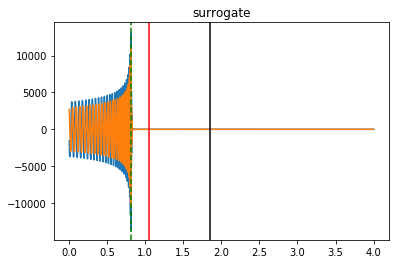

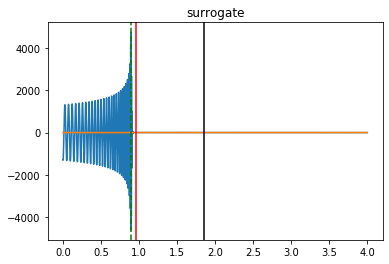

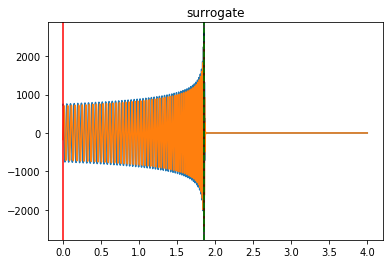

In [632]:
for i in range(hplus.shape[0]):
    plt.figure()
    plt.plot(surr_times_sec[i], hplus[i])
    plt.plot(surr_times_sec[i], hcross[i])
    plt.title("surrogate")
    plt.axvline(epochs[i], c='k')
    
    plt.axvline(epochs[i] + start_times[i], c='r')
    plt.axvline(-start_times[i], c='g', ls='--')
#     plt.xlim(epochs[i]-0.1 , epochs[i]+0.1)
#     plt.xlim(-start_times[i]-0.1 , -start_times[i]+0.1)
#     plt.xlim(0, seglen)
#     plt.xlim(0, 0.2)
    plt.show()
    plt.close()

In [633]:
sample_rate

0.000244140625

<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[    0],
       [13452]], dtype=int32)>

In [279]:
num_T = tf.cast(seglen / sample_rate, tf.int32)

In [280]:
num_T

<tf.Tensor: shape=(), dtype=int32, numpy=16384>

In [288]:
index_start_freq

<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[    0],
       [13452]], dtype=int32)>

In [289]:
index_peak_amp

<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[ 7717],
       [15435]], dtype=int32)>

In [301]:
surr_times_sec[0, index_start_freq[0,0]]

<tf.Tensor: shape=(), dtype=float64, numpy=0.0>

In [302]:
surr_times_sec[0, index_start_freq[1,0]]

<tf.Tensor: shape=(), dtype=float64, numpy=3.2841796217595305>

In [312]:
epochs

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[1.8842602 ],
       [3.76852041]])>

In [317]:
[ [index_start_freq[0,0], index_peak_amp[0,0]], [index_start_freq[1,0], index_peak_amp[1,0]] ]

[[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
  <tf.Tensor: shape=(), dtype=int32, numpy=7717>],
 [<tf.Tensor: shape=(), dtype=int32, numpy=13452>,
  <tf.Tensor: shape=(), dtype=int32, numpy=15435>]]

In [321]:
ab = tf.transpose((index_start_freq, index_peak_amp))

In [324]:
ab[0,0]

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([   0, 7717], dtype=int32)>

In [325]:
ab[0,1]

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([13452, 15435], dtype=int32)>

In [355]:
index_start_freq = tf.cast((epochs+start_times) / sample_rate, tf.int32)

In [361]:
tf.reshape(index_start_freq, -1)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([    0, 13452], dtype=int32)>

In [368]:
apply_roll(hplus*window, -tf.reshape(index_start_freq, -1))

<tf.Tensor: shape=(2, 16384), dtype=float32, numpy=
array([[ 1631.9078,  1691.046 ,  1749.28  , ...,     0.    ,     0.    ,
            0.    ],
       [-3226.667 , -3258.915 , -3289.3308, ...,    -0.    ,    -0.    ,
           -0.    ]], dtype=float32)>

tf.Tensor([-7.25133731e-10], shape=(1,), dtype=float64)


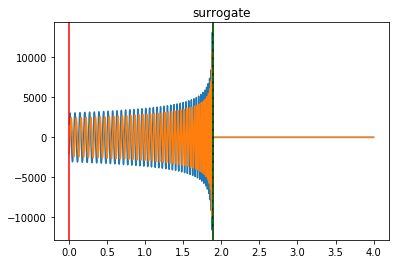

tf.Tensor([3.28438672], shape=(1,), dtype=float64)


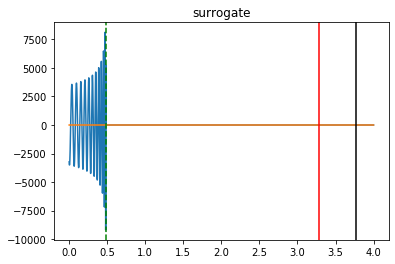

In [326]:

# indicies of the waveform at the start frequency requested
index_start_freq = tf.cast((epochs+start_times) / sample_rate, tf.int32)
index_peak_amp = tf.cast(epochs/sample_rate, tf.int32)

num_T = surr_times_sec.shape[1]

# window = make_rect_window_tensor(num_T, [ [index_start_freq[0,0], index_peak_amp[0,0]], [index_start_freq[1,0], index_peak_amp[1,0]] ])

ab = tf.transpose((index_start_freq, index_peak_amp))
window = make_rect_window_tensor(num_T, [ ab[0,0], ab[0,1] ])


for i in range(hplus.shape[0]):
    
    print(epochs[i] + start_times[i])
    
    plt.figure()
    plt.plot(surr_times_sec[i], tf.roll(hplus[i]*window[i], -index_start_freq[i,0], axis=0))
    plt.plot(surr_times_sec[i], tf.roll(hcross[i]*window[i], -index_start_freq[i,0], axis=0))

#     plt.plot(surr_times_sec[i], hplus[i]*window[i])
#     plt.plot(surr_times_sec[i], hcross[i]*window[i])

    plt.title("surrogate")
    plt.axvline(epochs[i], c='k')
    
    plt.axvline(epochs[i] + start_times[i], c='r')
    
    
    plt.axvline(-start_times[i], c='g', ls='--')
    
#     plt.xlim(epochs[i]-0.1 , epochs[i]+0.1)
#     plt.xlim(0, seglen)
#     plt.xlim(0, 0.2)
    plt.show()
    plt.close()

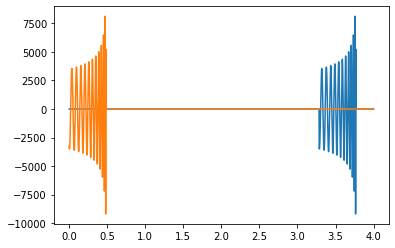

In [310]:
plt.figure()
plt.plot(surr_times_sec[1], hplus[1]*window[1])


plt.plot(surr_times_sec[1], tf.roll(hplus[1]*window[1], -index_start_freq[1,0], axis=0))


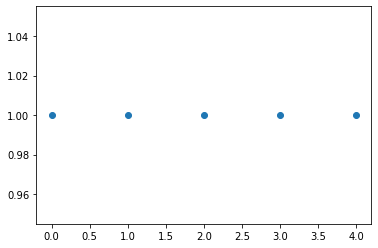

In [291]:
from scipy import signal
window = signal.windows.boxcar(5)
plt.plot(window, 'o')

In [76]:
import pycbc.waveform

In [77]:
import pycbc.types

In [78]:
params

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1., 0., 0.]], dtype=float32)>

In [79]:
# phenom.m1_m2_M_q(60, 4)

In [80]:
hp_pycbc, hc_pycbc = pycbc.waveform.get_td_waveform(mass1=30, mass2=30, f_lower=20, delta_t=1/2048./2, approximant="SEOBNRv4_opt",
                                                   distance=1/1e6/lal.PC_SI, inclination=np.pi/3)

Text(0.5, 1.0, 'pycbc')

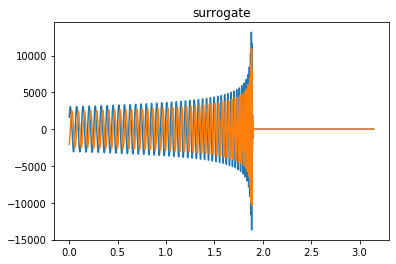

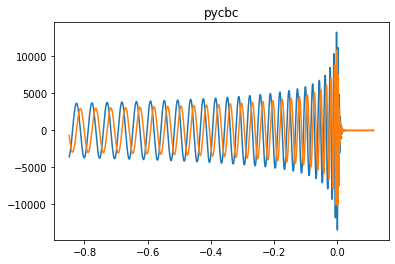

In [81]:
plt.figure()
plt.plot(surr_times_sec[0], hplus[0])
plt.plot(surr_times_sec[0], hcross[0])
plt.title("surrogate")
plt.figure()
plt.plot(hp_pycbc.sample_times, hp_pycbc)
plt.plot(hp_pycbc.sample_times, hc_pycbc)
plt.title("pycbc")
# plt.xlim(-1, 1)

In [82]:
annsur_dt = (surr_times_sec[0][1]-surr_times_sec[0][0]).numpy()

In [83]:
annsur_dt

0.0002441406201130203

In [84]:
annsur_dt

0.0002441406201130203

In [85]:
hp_pycbc.delta_t

0.000244140625

In [86]:
surr_times_sec.numpy()[0][-1]

3.1462401713957084

In [87]:
surr_times_sec[0,0].numpy()

0.0

In [88]:
surr_times_sec[0,0]

<tf.Tensor: shape=(), dtype=float64, numpy=0.0>

In [89]:
# here I think epoch is basically then lenght of the signal
# or almost equivalently the merger time

# note the change to float64 - when running the match the waveforms need to be the same dtype

hplus_ts = pycbc.types.TimeSeries(np.float64(hplus[0].numpy()), delta_t=np.float64(annsur_dt), epoch=float(surr_times_sec[0,0].numpy()))
hcross_ts = pycbc.types.TimeSeries(np.float64(hcross[0].numpy()), delta_t=np.float64(annsur_dt), epoch=float(surr_times_sec[0,0].numpy()))

# sometimes the annsur_dt is not high enough precision

# hplus_ts = pycbc.types.TimeSeries(np.float64(hplus[0].numpy()), delta_t=hp_pycbc.delta_t, epoch=float(surr_times_sec[0,0].numpy()))
# hcross_ts = pycbc.types.TimeSeries(np.float64(hcross[0].numpy()), delta_t=hp_pycbc.delta_t, epoch=float(surr_times_sec[0,0].numpy()))

In [90]:
hplus_ts.duration

3.1464843120166055

In [91]:
hcross_ts.duration

3.1464843120166055

In [92]:
hp_pycbc.duration

0.962890625

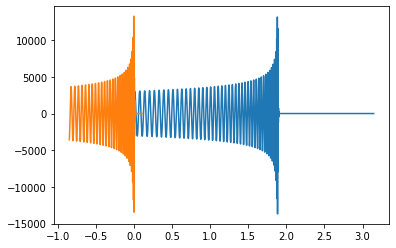

In [93]:
plt.figure()
plt.plot(hplus_ts.sample_times, hplus_ts)
plt.plot(hp_pycbc.sample_times, hp_pycbc)
# plt.xlim(-0.1,0.1)

In [94]:
import pycbc.filter
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower


In [95]:
hp_pycbc.sample_rate

4096

In [96]:
hplus_ts.sample_rate

4096

In [97]:
len(hp_pycbc)

3944

In [98]:
len(hplus_ts)

12888

In [99]:
f_low = 15

In [100]:
# Resize the waveforms to the same length
tlen = max(len(hp_pycbc), len(hplus_ts))
hp_pycbc.resize(tlen)
hplus_ts.resize(tlen)

In [101]:
# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / hp_pycbc.duration
flen = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)


In [102]:
hplus_ts.data.shape

(12888,)

In [103]:
hp_pycbc.data.shape

(12888,)

In [104]:
hplus_ts.delta_f

0.31781502808736156

In [105]:
hp_pycbc.delta_f

0.31781502172563625

In [106]:
hplus_ts.duration

3.1464843120166055

In [107]:
hp_pycbc.duration

3.146484375

In [108]:
hplus_ts.delta_t

0.0002441406201130203

In [109]:
len(hplus_ts)

12888

In [110]:
hp_pycbc.delta_t

0.000244140625

In [111]:
len(hp_pycbc)

12888

In [112]:
hplus_ts.data.dtype

dtype('float64')

In [113]:
hp_pycbc.data.dtype

dtype('float64')

In [114]:
psd.data.dtype

dtype('float64')

In [115]:
psd.delta_f

0.31781502172563625

In [116]:
m, i = match(hplus_ts, hp_pycbc, psd=psd, low_frequency_cutoff=f_low)
print('The match is: {:.4f}'.format(m))

The match is: 0.9829


In [117]:
h1, h2 = pycbc.waveform.utils.coalign_waveforms(hplus_ts, hp_pycbc)

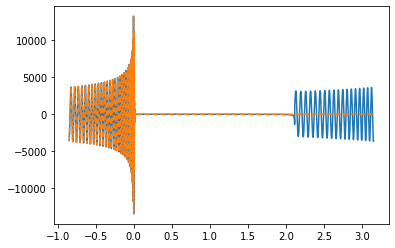

In [118]:
plt.figure()
plt.plot(h1.sample_times, h1)
plt.plot(h2.sample_times, h2, ls='--')
# plt.xlim(-0.4, 0.03)
# plt.xlim(-0.1, 0.03)

# try scrinet types

In [119]:
from scrinet.analysis.timeseries import TimeSeries
from scrinet.analysis.frequencyseries import FrequencySeries
from scrinet.analysis import matchedfilter

In [120]:
scrinet_hplus_ts = TimeSeries(hplus_ts.data, hplus_ts.delta_t, epoch=hplus_ts.sample_times[0])
scrinet_hp_pycbc = TimeSeries(hp_pycbc.data, hp_pycbc.delta_t, epoch=hp_pycbc.sample_times[0])

In [121]:
matchedfilter.match(scrinet_hplus_ts, scrinet_hp_pycbc) 

<tf.Tensor: shape=(), dtype=float64, numpy=0.8061437102985779>

In [122]:
h1, h2 = matchedfilter.coalign_waveforms(scrinet_hplus_ts, scrinet_hp_pycbc) 

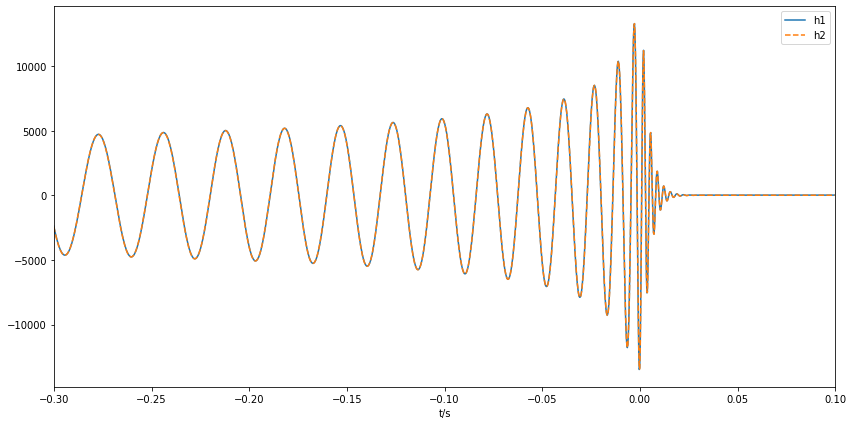

In [123]:
plt.figure(figsize=(14, 7))
plt.plot(h1.sample_times, h1.data, label='h1')
plt.plot(h2.sample_times, h2.data, ls='--', label='h2')
plt.xlabel('t/s')
plt.xlim(-0.3,0.1)
plt.legend()

In [124]:
scrinet_hplus_fs = scrinet_hplus_ts.to_frequencyseries()
scrinet_hp_pycbc_fs = scrinet_hp_pycbc.to_frequencyseries()

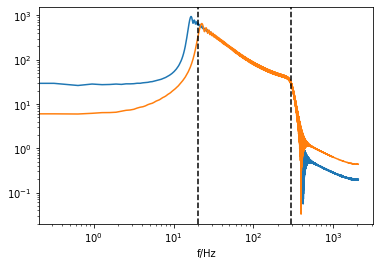

In [125]:
plt.figure()
plt.plot(scrinet_hplus_fs.sample_frequencies.numpy(), np.abs(scrinet_hplus_fs.data.numpy()))

plt.plot(scrinet_hp_pycbc_fs.sample_frequencies.numpy(), np.abs(scrinet_hp_pycbc_fs.data.numpy()))

plt.yscale('log')
plt.xscale('log')
plt.xlabel('f/Hz')
plt.axvline(20, ls='--', c='k')
plt.axvline(298, ls='--', c='k')


# working on f-domain detector frame generator

In [126]:
def gen_fdomain_pycbc_waveform_detframe()

SyntaxError: invalid syntax (<ipython-input-126-8ca6c2fec7f4>, line 1)

In [ ]:
from pycbc import psd as pypsd
from pycbc.inference.models import GaussianNoise
from pycbc.waveform.generator import (FDomainDetFrameGenerator,
                                      FDomainCBCGenerator)
seglen = 4
sample_rate = 2048
N = seglen*sample_rate/2+1
fmin = 30.
static_params = {'approximant': 'IMRPhenomD', 'f_lower': fmin,
                 'mass1': 30., 'mass2': 30.,
                 'spin1z': 0., 'spin2z': 0., 'ra': 1.37, 'dec': -1.26,
                 'polarization': 2.76, 'distance': 3*500.}
variable_params = ['tc']
tsig = 3.1
generator = FDomainDetFrameGenerator(
    FDomainCBCGenerator, 0., detectors=['H1', 'L1'],
    variable_args=variable_params,
    delta_f=1./seglen, **static_params)
signal = generator.generate(tc=tsig)
psd = pypsd.aLIGOZeroDetHighPower(N, 1./seglen, 20.)
psds = {'H1': psd, 'L1': psd}
low_frequency_cutoff = {'H1': fmin, 'L1': fmin}
model = GaussianNoise(variable_params, signal, low_frequency_cutoff,
                          psds=psds, static_params=static_params)

In [ ]:
model.update(tc=tsig)

In [ ]:
print('{:.2f}'.format(model.loglr))
print('{:.2f}'.format(model.logplr))

In [ ]:
signal

In [ ]:
plt.figure()
plt.plot(signal['H1'].sample_frequencies, np.abs(signal['H1']))

In [ ]:
print(f"delta_f = {signal['H1'].delta_f}")
print(f"delta_t = {signal['H1'].delta_t}")
print(f"duration = {signal['H1'].duration}")
print(f"start_time = {signal['H1'].start_time}")
print(f"end_time = {signal['H1'].end_time}")
print(f"epoch = {signal['H1'].epoch}")
print(f"sample_rate = {signal['H1'].sample_rate}")

In [ ]:
def get_annsur_fdomain(
    x,
    f_lower,
    sample_rate,
    theta,
    phi,
    mtot, 
    dist,
    phase_shift,
    amp_model,
    amp_basis,
    phase_model,
    phase_basis):
    
    times_sec, hp, hc = generate_surrogate_hp_hc(
        x,
        f_lower,
        sample_rate,
        theta,
        phi,
        mtot, 
        dist,
        phase_shift,
        amp_model,
        amp_basis,
        phase_model,
        phase_basis
    )
    
    
    
    hptilde = TimeSeries(hp, delta_t, epoch=times_sec[:,0])
    hctilde = TimeSeries(hc, delta_t, epoch=times_sec[:,0])
    

In [ ]:
TimeSeries()

In [ ]:
surr_times_sec[0,1]-surr_times_sec[0,0]

In [ ]:
surr_times_sec[1,1]-surr_times_sec[1,0]

In [ ]:
surr_times_sec[:,1]-surr_times_sec[:,0]

In [ ]:
x = tf.constant([
    [1,0,0]
], dtype=np.float32)
f_lower = 20
sample_rate_M = phenom.StoM(1/2048./2/2, 60)
theta = tf.constant([[np.pi/3]])
phi = tf.constant([[0.]])
mtot = tf.constant([[60.]])
dist = tf.constant([[1500 * 1e6 * lal.PC_SI]])
phase_shift = tf.constant([[0.]])

In [ ]:
# static_params

In [ ]:
hptilde, hctilde = get_annsur_fdomain(
    x=x,
    f_lower=f_lower,
    sample_rate=sample_rate_M,
    theta=theta,
    phi=phi,
    mtot=mtot,
    dist=dist,
    phase_shift=phase_shift,
    amp_model=amp_model,
    amp_basis=amp_basis,
    phase_model=phase_model,
    phase_basis=phase_basis
)